## TFM 2025  
### Autor : Andres Felipe Vargas Nuñez 
![](../Static_files/logo_ucm_ntic.png )

#### Este Archivo carga y valida modelos.  

In [1]:
import os 
import uuid
import joblib
import random

import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as mplt
import pandapower.networks as nw
import plotly.graph_objects as go

import pandapower.plotting as plt
import pandapower.timeseries as ts
from pandapower.control import ConstControl

from pandapower.timeseries.data_sources.frame_data import DFData



#### Métodos comunes de operación y manejo de datos.

In [147]:
def create_custom_network(num_buses, num_loads, connection_type="tree"):
    # Crear una red vacía
    net = pp.create_empty_network()
    buses = [pp.create_bus(net, vn_kv=110, name=f"Bus {i+1}") for i in range(num_buses)]

    loads = [
        pp.create_load(net, bus=buses[random.randint(0, num_buses - 1)], 
                       p_mw=random.uniform(1.0, 5.0), 
                       q_mvar=random.uniform(0.5, 2.5), 
                       name=f"Load {i+1}") 
        for i in range(num_loads)
    ]
    std_types = pp.available_std_types(net, element='line')
    if connection_type == "tree":
        for i in range(1, num_buses):
            parent_bus = random.choice(buses[:i])
            configuracion_aleatoria = random.choice(list(std_types.index))
            pp.create_line(net,name=f"line {i+1}" ,from_bus=parent_bus, to_bus=buses[i], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)
                
    elif connection_type == "mesh":
        for i in range(1, num_buses):
            for j in range(i):
                if random.random() < 0.5:  
                    configuracion_aleatoria = random.choice(list(std_types.index))
                    pp.create_line(net, from_bus=buses[i], to_bus=buses[j], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)
                    
    elif connection_type == "ring":
        for i in range(num_buses):
            configuracion_aleatoria = random.choice(list(std_types.index))
            pp.create_line(net, from_bus=buses[i], to_bus=buses[(i+1) % num_buses], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)

            if random.random() < 0.3:  
                distant_bus = random.choice(buses)
                if distant_bus != buses[i] and distant_bus != buses[(i+1) % num_buses]:
                    pp.create_line(net, from_bus=buses[i], to_bus=distant_bus, length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)

    else:
        raise ValueError("Tipo de conexión no válido. Usa 'tree' o 'ring'.")

    slack_bus = 0
    pp.create_gen(net, bus=slack_bus, p_mw=random.uniform(5.0, 10.0), vm_pu=1.02, slack=True, name="Slack Gen")
    pp.create_ext_grid(net, bus=slack_bus, vm_pu=1.02)

    return net

def create_network(net_type=0):
    if net_type == 0:
        net =nw.simple_four_bus_system()
    elif net_type == 1:   
        net =nw.case24_ieee_rts()
    elif net_type == 2:
        net = nw.case30()
    else:
        net = nw.case14()
    return net

def calculate_resistance(distance_km):
    resistivity = 0.017 
    area = 1.0  
    resistance = (resistivity / area) * distance_km
    return resistance

def configure_output_writer(net, output_path):
    return ts.OutputWriter(net, output_path=output_path, output_file_type=".xlsx")

def create_profile_data(time_steps, net):
    profile_data = np.random.rand(time_steps, len(net.load))
    return ts.DFData(pd.DataFrame(profile_data))

def configure_constant_load_control(net, ds):
    return ConstControl(net, element='load', element_index=net.load.index, variable='scaling', data_source=ds, profile_name=net.load.index)

def log_variables(ow):
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_gen', 'p_mw')
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_load', 'q_mvar')

def run_simulation(net, time_steps) -> bool:
    try:
        ts.run_timeseries(net, time_steps)
        return True
    except Exception as e:
        print(f"Error durante la ejecución de series temporales: {e}")
        return False

def load_results(output_path):
    res_bus = pd.read_excel(f'{output_path}/res_bus/vm_pu.xlsx', header=None)
    res_load_p_mw = pd.read_excel(f'{output_path}/res_load/p_mw.xlsx', header=None)
    res_load_q_mvar = pd.read_excel(f'{output_path}/res_load/q_mvar.xlsx', header=None)
    res_line = pd.read_excel(f'{output_path}/res_line/loading_percent.xlsx')
    lines_config = pd.read_csv(f'{output_path}/line_configuration.csv', header=0)
    loads_config = pd.read_csv(f'{output_path}/loads_configuration.csv', header=0)
    return res_bus, res_load_p_mw, res_load_q_mvar, res_line , lines_config, loads_config

def format_load_data(res_load, load_bus_ids, value_name):
    res_load.columns = ['time_step'] + [f'{bus}' for bus in load_bus_ids]
    res_load = res_load[~res_load['time_step'].isna()]
    res_load = res_load.reset_index().melt(id_vars=['index'], var_name='node_id', value_name=value_name)
    res_load = res_load.query("node_id != 'time_step'")
    return res_load

def format_bus_data(res_bus, max_range):
    res_bus.columns = ['time_step', 'line_id'] + [f'{bus}' for bus in range(1, max_range)]
    res_bus = res_bus[~res_bus['time_step'].isna()]
    res_bus = res_bus.reset_index().melt(id_vars=['index'], var_name='node_id', value_name='vm_pu')
    res_bus = res_bus.query("node_id != 'time_step' & node_id != 'line_id'")
    return res_bus

def merge_data(res_bus, res_load_p_mw, res_load_q_mvar):
    res_load_p_mw.set_index(['index', 'node_id'], inplace=True)
    res_bus.set_index(['index', 'node_id'], inplace=True)
    res_load_q_mvar.set_index(['index', 'node_id'], inplace=True)
    df_combined = res_bus.join(res_load_p_mw, on=['index', 'node_id'] ,lsuffix='__bus', rsuffix='_loadp') 
    df_combined = df_combined.join(res_load_q_mvar, on=['index', 'node_id'], how="left",rsuffix='_loadq')
    return df_combined

def create_incidence_matrix(net):
    incidence_matrix = pp.topology.create_nxgraph(net)
    return pd.DataFrame(nw.to_pandas_adjacency(incidence_matrix, nodelist=net.bus.index, weight='weight'))

def create_line_data(net):
    line_data = []
    for line in net.line.index:
        from_bus = net.line.from_bus.at[line]
        to_bus = net.line.to_bus.at[line]
        length_km = net.line.length_km.at[line]
        r_ohm_per_km = net.line.r_ohm_per_km.at[line]
        line_data.append({'line_id': line, 'from_bus': from_bus, 'to_bus': to_bus, 'length_km': length_km, 'r_ohm_per_km': r_ohm_per_km})
    return pd.DataFrame(line_data)

def print_inciden_matrix(df):
    df = df.applymap(lambda x: 0 if x == '0' or x == 0 else 1)

def incidence_matrix(line_df):
    from_buses = line_df['from_bus']
    to_buses = line_df['to_bus']
    length_kms = line_df['length_km']
    r_ohm_per_kms = line_df['r_ohm_per_km']
    num_buses = max(from_buses.max(), to_buses.max()) + 1
    num_lines = len(line_df)
    incidence_matrix = np.zeros((num_buses, num_lines), dtype=tuple)
    # (length_km,r_ohm_per_km
    for i, (from_bus, to_bus,length_km,r_ohm_per_km) in enumerate(zip(from_buses, to_buses,length_kms,r_ohm_per_kms)):
        incidence_matrix[from_bus, i] = 1
        incidence_matrix[to_bus, i] = 1

    df = pd.DataFrame(incidence_matrix, columns=[i for i in range(num_lines)], index=[j for j in range(num_buses)])

    return df

def plot_simple_df_net(df, is_print_lines=False):
    # df = df.transpose()
    
    net = pp.create_empty_network()
    buses = [pp.create_bus(net, vn_kv=110, name=f"Bus {bus}") for bus in range(len(df.index))]
    number_line = 0

    for col in df.columns:
        from_bus = None
        to_bus = None
        for i, value in df[col].items():
                if value == 1 and from_bus is None:
                        from_bus = int(i)
                if value == 0.68 and to_bus is None:
                        to_bus = int(i)
        
        if  (not from_bus is None and 
        not to_bus is None ): 
                length_km = 10
                pp.create_line(net, name=f"number_line{number_line}", from_bus=from_bus, to_bus=to_bus, length_km=length_km, std_type="NAYY 4x50 SE")
                number_line += 1

    slack_bus = 0 
    pp.create_gen(net, bus=slack_bus, p_mw=random.uniform(5.0, 10.0), vm_pu=1.02, slack=True, name="Slack Gen")
    other_gen_buses = random.sample([b for b in buses if b != slack_bus], k=max(1,  len(df.index) // 4))
    for bus in other_gen_buses:
        pp.create_gen(net, bus=bus, p_mw=random.uniform(3.0, 6.0), vm_pu=1.02, name=f"Gen {bus}")

    pp.create_ext_grid(net, bus=slack_bus, vm_pu=1.02)
    fig = plt.simple_plot(net)
    if is_print_lines:
        print(net.line)


def comparar_matrices(matrix1, matrix2):
    df_resta = matrix1 - matrix2
    suma_total = df_resta.values.sum()
    return suma_total

def ajustar_celdas(df,y=0.4):
    df_nuevo = pd.DataFrame(0, index=df.index, columns=df.columns)
    for col in df.columns:
        top_values = df[col].nlargest(2)
        if len(top_values) > 0:
            top_indices = top_values.index
            if top_values.sum() < y :
                continue
            if len(top_indices) > 0:
                df_nuevo.loc[top_indices[0], col] = 0.68
            if len(top_indices) > 1:
                df_nuevo.loc[top_indices[1], col] = 1
    return df_nuevo

def print_bw_matrix(df):
    mplt.matshow(df, cmap='gray')
    mplt.xticks(ticks=np.arange(df.shape[1]), labels=df.columns)
    mplt.yticks(ticks=np.arange(df.shape[0]), labels=df.index)
    mplt.colorbar()
    mplt.show()

def print_int_matrix(df,text="Generate Model Data"):
    print("*" *30 + text + "*"*30)
    print( "*"*60 + "*" *len(text) )
    print(df)

def plot_and_print_result(df,text:str="Generate Model Data" , type_output:int = 0):
    if type_output == 1 :
        print_int_matrix(df,text)
    elif type_output ==  2:
        print_bw_matrix(df)
    elif type_output ==  3:
        plot_simple_df_net(df)
    return True

#### configuración de los datos de comprobación.

In [110]:
max_size_nodes = 24
nodes = 18
lines = nodes-1
loads = 9
num_intervals = 48
base_output_path = f"../Data-3"
folder_name = "Validation"
y_size=max_size_nodes-1
x_size=max_size_nodes


#### Lectura y organización información de comprobación.

In [140]:

common_folder=f"{base_output_path}/train_data/{folder_name}/"
train_files = [os.path.join(common_folder, nombre) for nombre in os.listdir(common_folder)]
df_total=pd.DataFrame()

def pad_dataframe(df, max_size):
    padded_array = np.zeros(((max_size), max_size-1))
    rows, cols = df.shape
    padded_array[:rows, :cols] = df.values

    return pd.DataFrame(padded_array)

def add_columns(df, prefix, total_columns):
   columns = [col.split("_")[-1] for col in df.columns if prefix in col ] 
   max_col = max(columns)
   for col in range( int(max_col) , total_columns+1):
       column = f" {prefix}{col}"
       df[column]= 0.0
       
       
   return df

def parse_tuple(x):
    if x == '0':
        return 0
    else:
        return 1

for folder in (train_files):
    load_csv_file = f'{folder}/load/load.csv' 
    df = pd.read_csv(load_csv_file,index_col=[0] ,header=[0])
    incidence_matrix_file = f'{folder}/indicen_matriz/incidence_matrix.csv'
    df_incidence_matrix = pd.read_csv(incidence_matrix_file,index_col=[0])
    df_incidence_matrix = df_incidence_matrix.replace(3, 0.68)
    df_incidence_matrix = df_incidence_matrix.replace(5, 1)
    df_incidence_matrix = df_incidence_matrix.transpose()
    parsed_df = pad_dataframe(df_incidence_matrix, max_size_nodes)
    t  = np.array(parsed_df).flatten()
    df["Y"] =  [t] * len(df) 
    df_total=pd.concat([df_total,df])


df_total = add_columns(df_total, 'va_degree_', max_size_nodes)
df_total = add_columns(df_total, 'res_p_', max_size_nodes)
df_total = add_columns(df_total, 'res_q_', max_size_nodes)
df_total = add_columns(df_total, 'vm_pu_', max_size_nodes)
df_total = df_total.fillna(0)
columnas_excluir = ['nodes_numbers', 'loads_number', 'Y']
df_total[columnas_excluir] = df_total[columnas_excluir]
df_restantes = df_total.drop(columns=columnas_excluir).astype(float)
df_total = pd.concat([df_total[columnas_excluir], df_restantes], axis=1)

df_total = df_total.sort_index(axis=1)
print(df_total.shape)

C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\1539716340.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column]= 0.0
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\1539716340.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column]= 0.0
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\1539716340.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

(16128, 129)


In [112]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

columns_out= ['Y']
scaler = MinMaxScaler()
X = df_total.drop(columns_out,axis=1).values
X =  scaler.fit_transform(X)
Y = df_total[columns_out].values
num_samples = len(X) // num_intervals
X = X.reshape((num_samples,num_intervals,len(df_total.drop(columns_out,axis=1).columns)))
Y = (df_total['Y'].values)
Y = np.stack(Y)
Y = Y.reshape((num_samples, num_intervals,max_size_nodes, max_size_nodes-1 ))
print(X.shape, Y.shape)


(336, 48, 128) (336, 48, 24, 23)


#### Lectura de modelo y validación.

*************** Validacion modelos ******************
************ Casos de pruebas  48 *******
 modelo evaluado model_test
index_prev : 0  index : 47
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step
(47, 48, 24, 23)
               0             1             2             3             4  \
0   9.986987e-01  9.640003e-01  1.738198e-03  1.510335e-02  7.502583e-01   
1   2.563881e-01  5.120010e-05  3.359907e-02  2.722679e-01  2.132580e-02   
2   2.894857e-03  7.875988e-06  1.879936e-03  1.488834e-03  1.409366e-02   
3   6.405784e-01  1.042663e-05  9.965107e-01  7.310162e-01  9.991014e-01   
4   1.867877e-03  2.760809e-06  2.831297e-04  1.415456e-03  4.057768e-03   
5   3.371740e-04  8.808359e-03  3.784437e-06  1.562670e-05  4.449856e-05   
6   1.415463e-02  1.202738e-01  8.762685e-03  4.691542e-03  1.084795e-03   
7   2.621554e-02  9.020587e-05  1.850597e-03  4.504531e-01  2.370888e-02   
8   4.696581e-03  6.495947e-03  6.236027e-0

C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.6

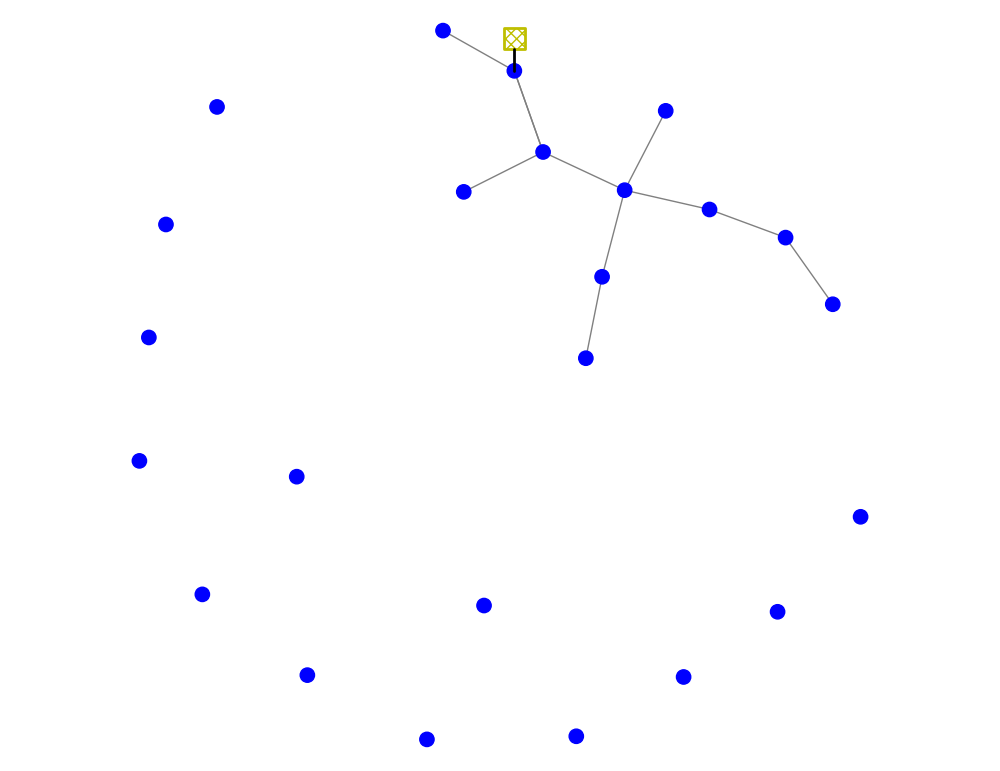

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


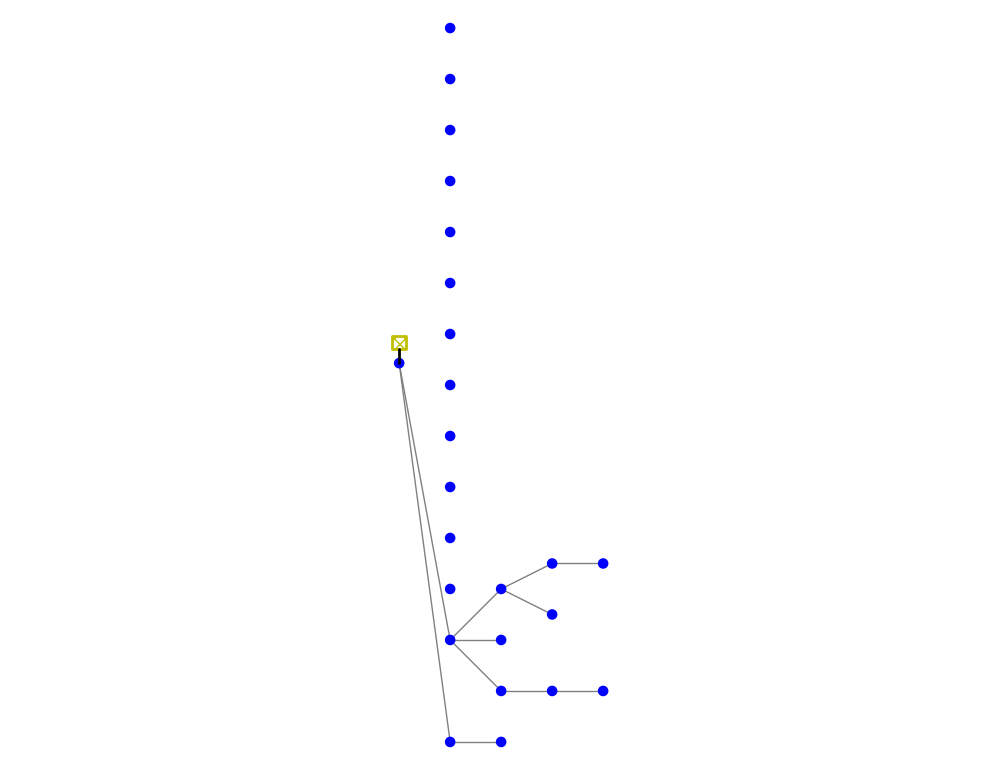

index_prev : 48  index : 94
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
(46, 48, 24, 23)
               0             1             2             3             4  \
0   9.149460e-01  6.690439e-01  1.764754e-01  3.489375e-01  5.938981e-03   
1   3.332148e-02  1.243759e-02  6.000683e-02  3.622268e-04  4.017253e-04   
2   3.195152e-02  4.072801e-02  5.514259e-04  2.442295e-02  3.886109e-04   
3   1.520975e-01  3.766509e-02  8.251520e-02  5.997964e-01  2.408698e-01   
4   7.370736e-04  9.941587e-04  9.876650e-05  7.490147e-03  2.283203e-02   
5   2.088737e-03  2.560354e-03  1.436074e-02  2.643924e-03  9.547949e-03   
6   1.937096e-02  4.366857e-02  9.505764e-02  1.024300e-02  6.650190e-02   
7   2.586871e-03  2.068217e-03  7.004573e-04  9.373471e-03  1.490444e-03   
8   3.203428e-03  1.831116e-04  1.671146e-03  5.739477e-03  1.064072e-02   
9   1.521533e-01  4.020258e-01  4.972834e-02  6.164360e-02  8.117769e-02   
10  1.289610e-

C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.6

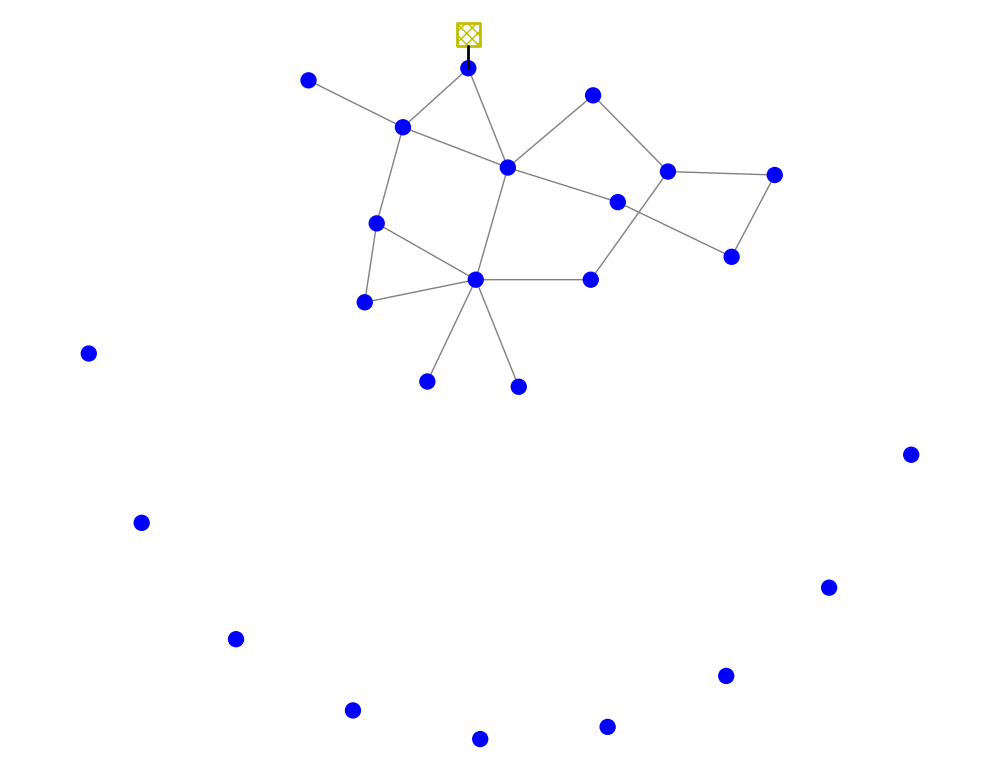

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


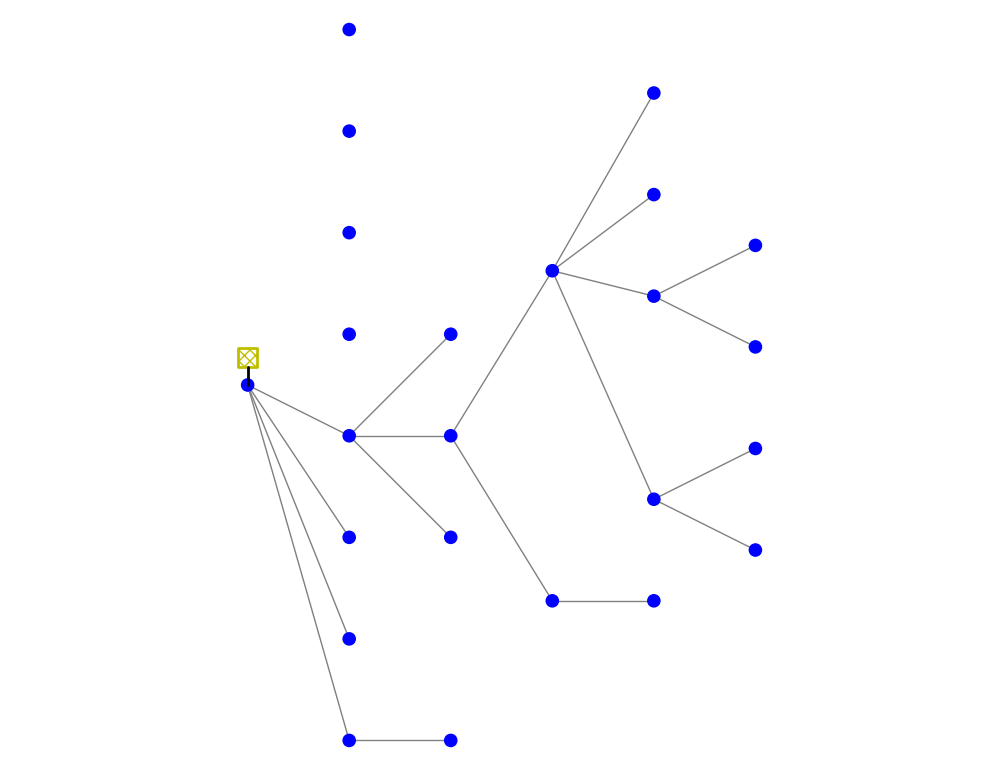

index_prev : 95  index : 141
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
(46, 48, 24, 23)
               0             1             2             3             4  \
0   9.134346e-01  6.869393e-01  1.499579e-01  3.658002e-01  6.060256e-03   
1   3.159918e-02  9.114301e-03  5.711913e-02  3.551973e-04  4.053061e-04   
2   3.398174e-02  4.330254e-02  7.061026e-04  2.652538e-02  3.865302e-04   
3   1.484714e-01  3.688180e-02  8.176476e-02  5.951258e-01  2.407840e-01   
4   6.339030e-04  1.054056e-03  9.346232e-05  7.228589e-03  2.133658e-02   
5   1.995414e-03  2.342543e-03  1.412039e-02  2.431723e-03  9.082340e-03   
6   1.834713e-02  4.184697e-02  9.751359e-02  9.662272e-03  5.813832e-02   
7   2.337961e-03  1.905634e-03  5.539212e-04  8.898146e-03  1.195697e-03   
8   2.782908e-03  1.811142e-04  1.392069e-03  5.131856e-03  9.661616e-03   
9   1.572820e-01  4.096483e-01  4.736446e-02  6.405812e-02  8.325879e-02   
10  1.299441e

C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.6

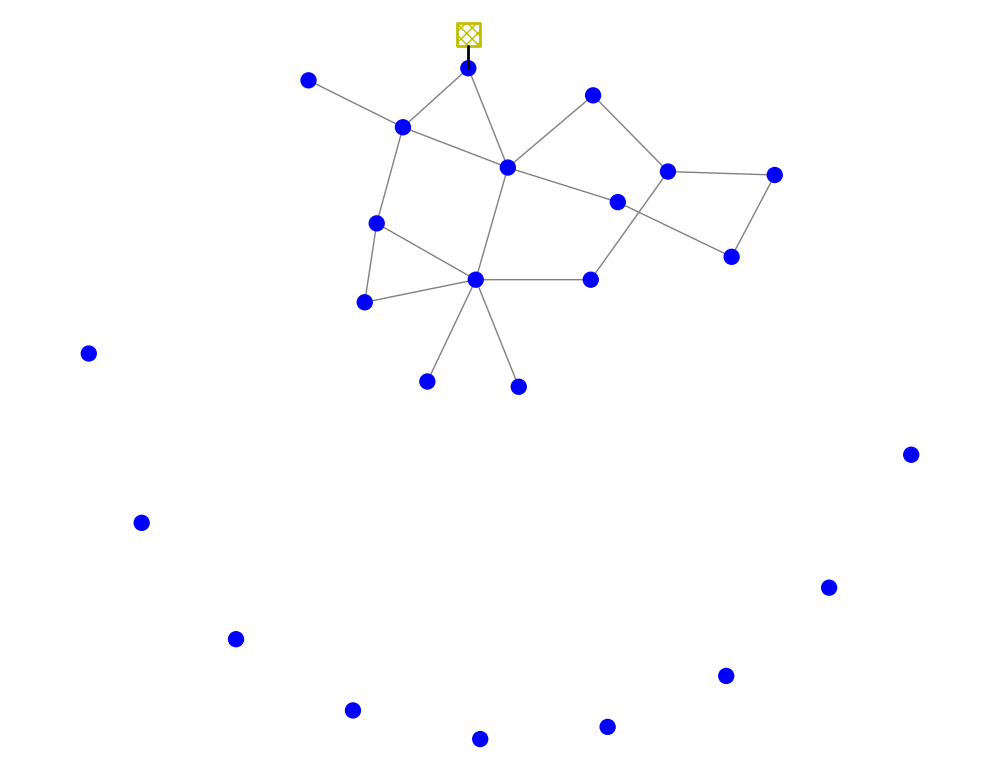

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


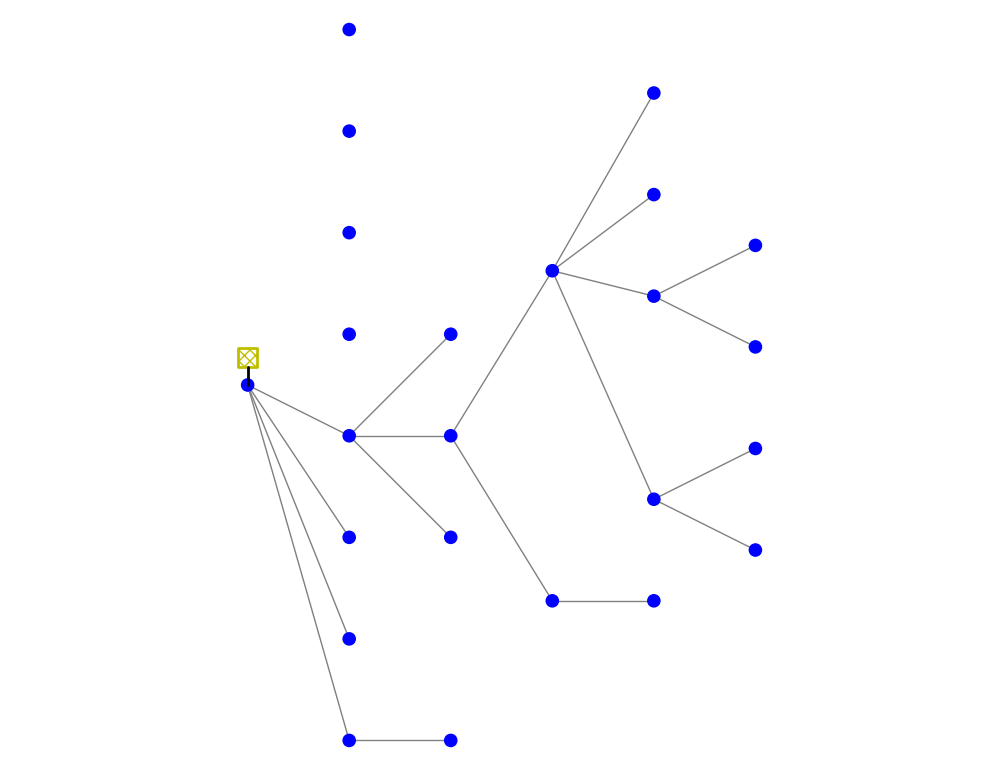

index_prev : 142  index : 188
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step 
(46, 48, 24, 23)
           0             1             2             3             4  \
0   0.997648  1.693758e-01  8.349218e-01  1.088956e-01  1.110600e-01   
1   0.001981  1.609663e-03  3.120451e-03  8.828354e-05  3.684517e-04   
2   0.002982  1.304672e-03  6.645650e-04  4.156915e-04  5.930979e-03   
3   0.014428  1.541117e-02  2.185326e-02  1.967401e-03  2.450159e-02   
4   0.013115  1.611301e-04  7.202397e-03  9.578576e-05  1.075766e-03   
5   0.066543  1.787275e-01  1.029692e-02  4.999884e-01  7.743435e-02   
6   0.010688  3.279527e-03  1.772794e-01  2.845819e-02  3.132366e-02   
7   0.000918  3.784708e-03  1.847489e-02  3.052415e-04  3.160866e-03   
8   0.131267  2.430424e-02  3.383456e-02  1.773444e-02  4.457235e-02   
9   0.054906  8.688358e-02  3.097942e-02  2.111746e-01  3.449219e-01   
10  0.040518  1.090216e-01  3.340992e-01  1.028575e-01  1.357600e-01   
11  0.040626  5.1

C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.6

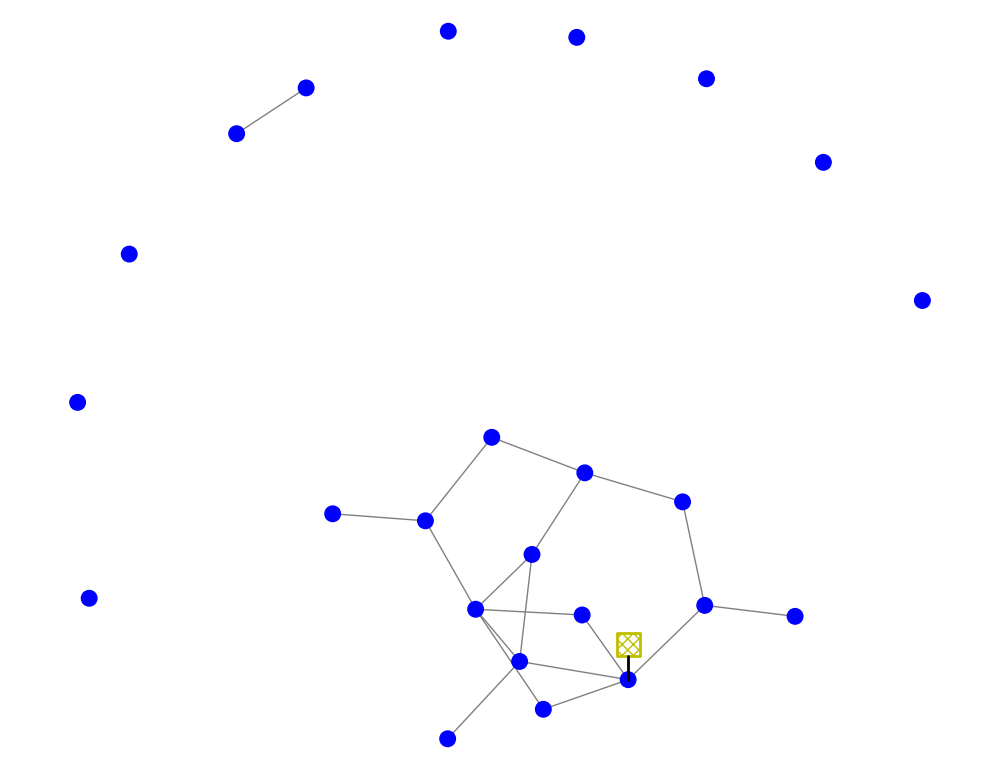

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


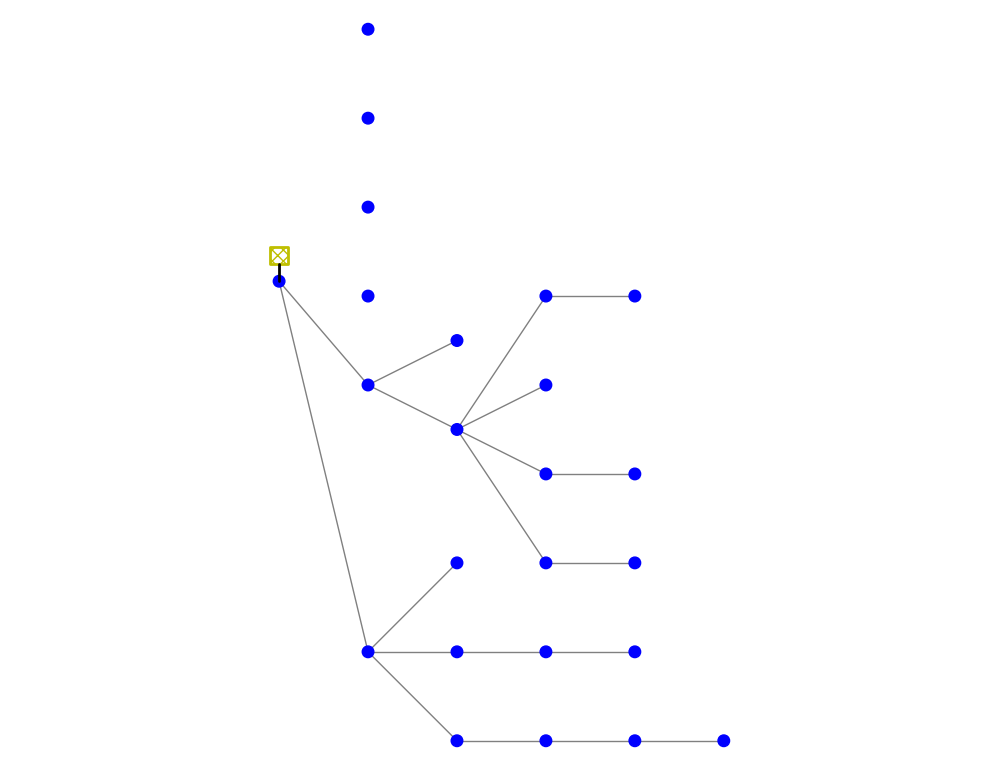

index_prev : 189  index : 235
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
(46, 48, 24, 23)
           0             1             2             3             4  \
0   0.996629  9.980044e-01  2.898721e-02  2.902021e-01  1.455708e-05   
1   0.065651  4.172924e-05  2.883197e-01  2.570142e-03  1.780376e-02   
2   0.020172  4.231445e-02  5.754147e-01  2.685766e-02  1.117227e-01   
3   0.125105  8.876359e-02  8.804692e-02  9.788763e-02  2.535901e-03   
4   0.037587  1.873475e-01  4.008838e-02  2.857986e-03  7.527108e-04   
5   0.007140  2.572116e-02  1.666329e-02  2.688077e-02  1.058932e-02   
6   0.007600  2.943171e-05  7.423909e-03  8.303195e-03  1.366246e-01   
7   0.161891  1.754108e-02  2.033490e-01  9.588442e-03  3.087851e-02   
8   0.000863  1.878492e-03  3.437142e-04  8.926321e-04  9.854870e-03   
9   0.061962  1.008093e-02  5.223400e-03  3.706985e-03  2.705144e-01   
10  0.070220  2.569691e-03  2.417019e-01  1.320359e-02  

C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.6

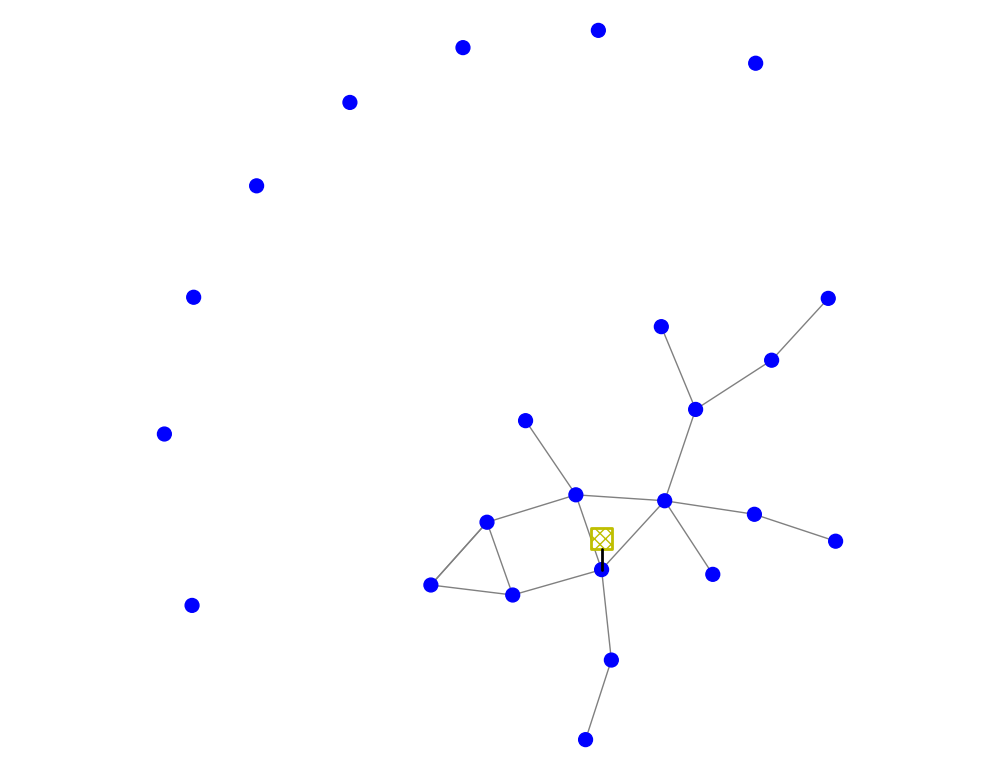

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


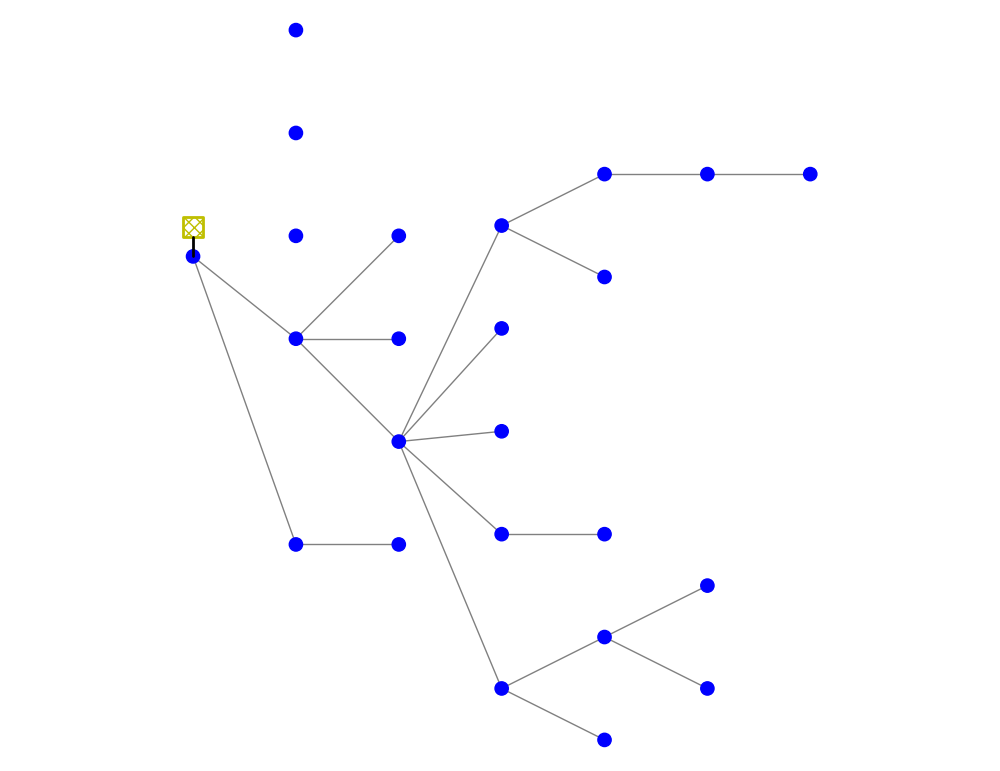

index_prev : 236  index : 282
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step 
(46, 48, 24, 23)
           0             1             2             3         4  \
0   0.995193  9.859480e-01  8.288801e-01  8.000789e-02  0.129980   
1   0.003509  1.439904e-04  6.718798e-03  1.065656e-02  0.004562   
2   0.002589  1.300932e-02  6.540397e-03  5.546789e-03  0.036032   
3   0.014190  1.418254e-02  2.332144e-02  5.804158e-04  0.069974   
4   0.026674  2.670086e-04  1.768799e-02  1.026247e-02  0.029561   
5   0.096560  4.183535e-03  3.285955e-03  1.691568e-01  0.117494   
6   0.001635  1.546638e-03  6.401036e-03  1.655904e-04  0.000944   
7   0.019937  9.532615e-03  8.375943e-03  1.015871e-02  0.000217   
8   0.015757  1.502630e-02  2.216379e-02  1.051920e-01  0.069222   
9   0.035878  2.120902e-05  1.116783e-01  4.624392e-02  0.258566   
10  0.007334  4.836265e-05  6.419905e-02  1.210376e-02  0.010560   
11  0.018854  1.670866e-01  4.442460e-03  9.862680e-03  0.012312 

C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.6

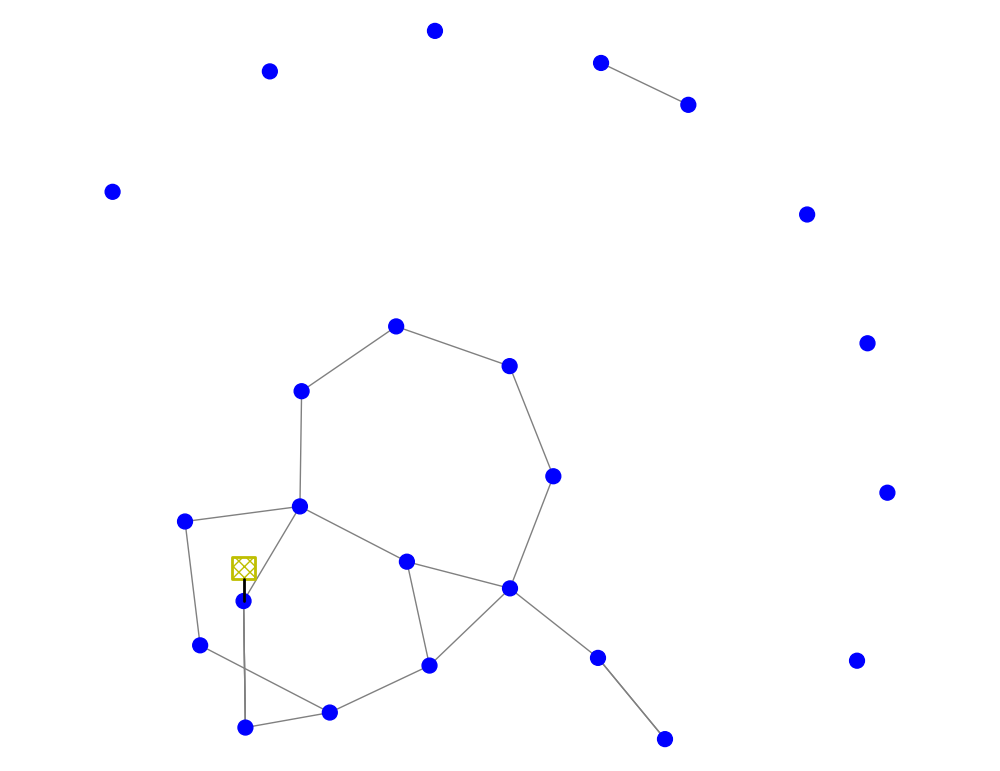

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


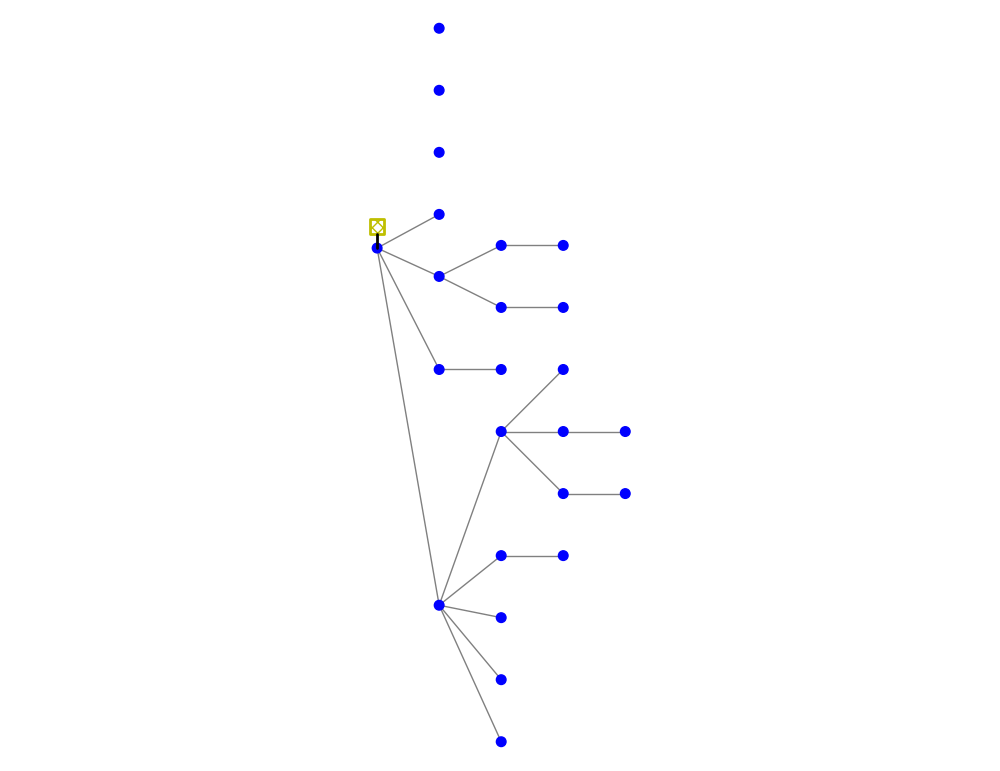

index_prev : 283  index : 329
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step 
(46, 48, 24, 23)
           0         1         2         3         4         5         6  \
0   0.998969  0.507524  0.367385  0.160699  0.441910  0.750875  0.589474   
1   0.031929  0.004817  0.010127  0.005915  0.561885  0.012269  0.005660   
2   0.000926  0.001624  0.000399  0.000039  0.000006  0.000111  0.000051   
3   0.010687  0.000079  0.003139  0.051083  0.024212  0.033227  0.110395   
4   0.054664  0.374433  0.002651  0.074358  0.895261  0.020019  0.001826   
5   0.050378  0.166981  0.008988  0.003006  0.004327  0.001632  0.013213   
6   0.003966  0.002255  0.001893  0.006058  0.007201  0.002443  0.076027   
7   0.057321  0.001976  0.189715  0.041046  0.005684  0.019734  0.242495   
8   0.016988  0.078587  0.285179  0.014563  0.009630  0.032620  0.013461   
9   0.005540  0.018513  0.011376  0.000830  0.002590  0.003613  0.000172   
10  0.007744  0.002992  0.001394  0.001908  0

C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_24360\3929627960.py:201: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[0], col] = 0.6

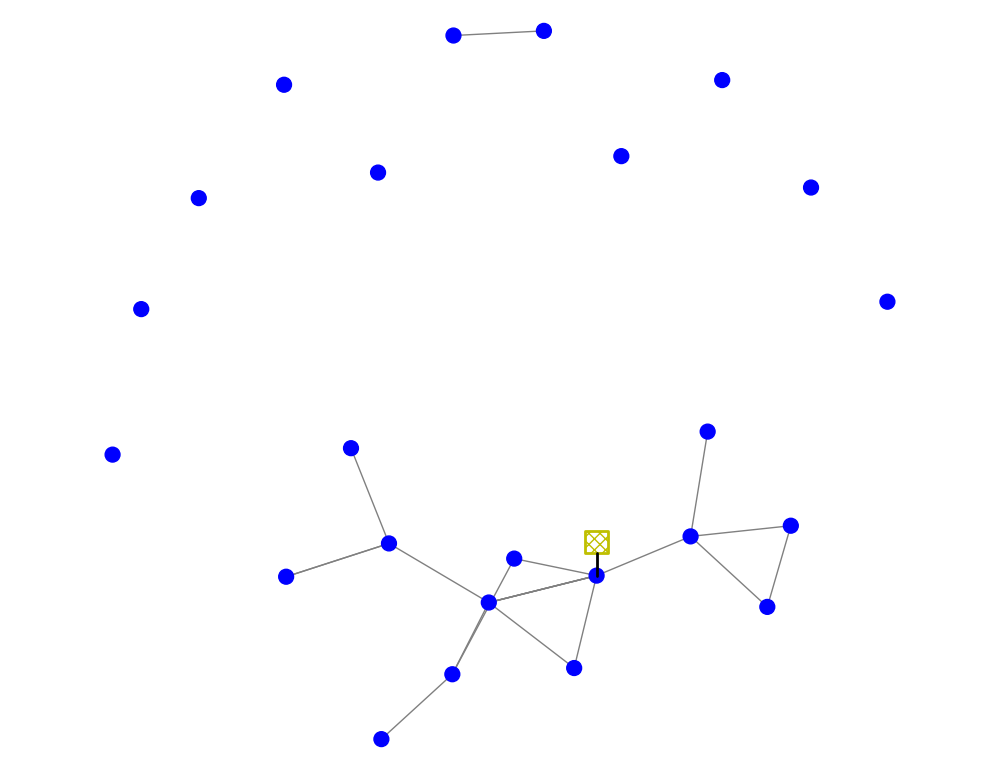

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


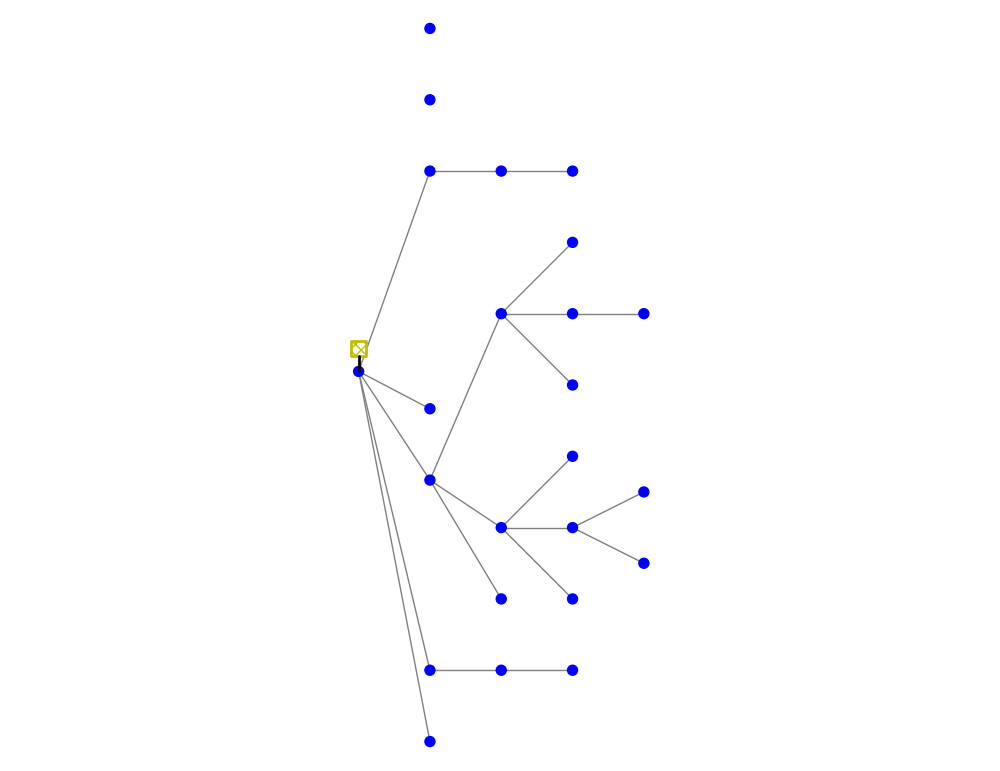

 Resultados 
[0.015657971014492754, 0.09160579710144928, 0.09160579710144928, 0.08588985507246377, 0.09063188405797103, 0.09313623188405798, 0.09267826086956522]
[]
[16.98434202898551, 16.90839420289855, 16.90839420289855, 16.914110144927538, 16.90936811594203, 16.906863768115944, 16.907321739130435]
118.43879420289855
119
0.0


In [148]:
results =[]
interval=47

import joblib
model_output_path ="../Modelos/{}"
model_cargado = joblib.load(model_output_path.format("model_lstm_cnn_V3_final"))

models = {
    "model_test":model_cargado,
        }

type_output = 3
number_eval = int(len(X)/7)

print("*************** Validacion modelos ******************")
print(f"************ Casos de pruebas  {number_eval} *******")
# number_eval = 1
for model_name , model_val in models.items() :
    print(f" modelo evaluado {model_name}")
    results = []
    index_prev=0
    for index in range(47,len(X),47): 
        print(f"index_prev : {index_prev}  index : {index }")
        predicted_image = model_val.predict(X[index_prev:index])
        print(predicted_image.shape)
        test_image = predicted_image[0][0]

        data_out = []
        for i in range(test_image.shape[0]):
            row = []
            for j in range(test_image.shape[1]):
                # val = 1 if np.abs((test_image[i, j])) > 0.4 else 0
                val = test_image[i, j]
                row.append(val)
            data_out.append(row)

        df_topo_out = pd.DataFrame(data_out, columns=[f'{i}' for i in range(test_image.shape[1])])
        print(df_topo_out)
        df_topo_out = ajustar_celdas(df_topo_out,y=0.2)
        plot_and_print_result(df_topo_out ,"Test Evaluate Data",type_output=type_output)
        # print_bw_matrix(df_topo_out)

        

        test_image_val = Y[index_prev:index][0][interval]
        data_val = []
        for i in range(test_image_val.shape[0]):
            row = []
            for j in range(test_image_val.shape[1]):
                row.append(test_image_val[i, j])
            data_val.append(row)

        df_topo_val = pd.DataFrame(data_val, columns=[f'{i}' for i in range(test_image_val.shape[1])])
        # print(df_topo_val)
        plot_and_print_result(df_topo_val ,"Test Model Data",type_output=type_output)
        mse = np.mean((df_topo_out - df_topo_val)**2)
        results.append(mse)
        index_prev = index + 1


    val_reuslt = ([True for result in results if result == lines])
    val_reuslt_sum = ([lines-result for result in results ])
    print("="*30)
    print(" Resultados ")
    print((results))
    print((val_reuslt))
    print((val_reuslt_sum))
    print(sum(val_reuslt_sum))
    print(len(results)*lines)
    print(len(val_reuslt)/len(results))
    print("="*30)